# Data Preprocessing

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
crying_dataset = "Dataset/Cry_Datasets"
screaming_dataset = "Dataset/Screaming_Datasets"
normal_utterance_datasets = "Dataset/Normal_Utterances_Datasets"

In [3]:
import os

def count_files_and_find_same_names(*dirs):
    file_counts = {}
    initial_counts = {}
    file_names = {}
    same_names = set()
    
    for directory in dirs:
        if not os.path.exists(directory):
            print(f"Warning: {directory} does not exist.")
            continue
        
        all_files = os.listdir(directory)
        initial_counts[directory] = len(all_files)
        files = set(f for f in all_files if f.endswith((".wav", ".mp3")))
        file_counts[directory] = len(files)
        
        for file in files:
            if file in file_names:
                same_names.add(file)
            file_names[file] = file_names.get(file, []) + [directory]
    
    removed_percentage = {
        directory: ((initial_counts[directory] - file_counts[directory]) / initial_counts[directory] * 100) if initial_counts[directory] > 0 else 0
        for directory in dirs
    }
    
    return file_counts, same_names, file_names, removed_percentage

# Get file counts, same names, and removed percentage
file_counts, same_names, file_names, removed_percentage = count_files_and_find_same_names(
    crying_dataset, screaming_dataset, normal_utterance_datasets
)

# Print results
print("File counts in each dataset:")
for dataset, count in file_counts.items():
    print(f"{dataset}: {count} files")

if same_names:
    print("\nFiles with the same name found:")
    for name in same_names:
        print(f"{name}: Present in {file_names[name]}")
else:
    print("\nNo files with the same name found.")

print("\nPercentage of files removed:")
for dataset, percentage in removed_percentage.items():
    print(f"{dataset}: {percentage:.2f}% removed")


File counts in each dataset:
Dataset/Cry_Datasets: 514 files
Dataset/Screaming_Datasets: 862 files
Dataset/Normal_Utterances_Datasets: 40707 files

No files with the same name found.

Percentage of files removed:
Dataset/Cry_Datasets: 1.15% removed
Dataset/Screaming_Datasets: 0.00% removed
Dataset/Normal_Utterances_Datasets: 0.00% removed


Processing crying dataset in batches:   0%|          | 0/11 [00:00<?, ?it/s]/home/pratyush/miniconda3/envs/tf_env/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/pratyush/miniconda3/envs/tf_env/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
Processing normal dataset in batches: 100%|██████████| 815/815 [09:03<00:00,  1.50it/s]


Class Weights: {'crying': 1.0, 'screaming': 1.0, 'normal': 1.0}
Total data points: 4470
Class distribution: {'crying': 1490, 'screaming': 1490, 'normal': 1490}


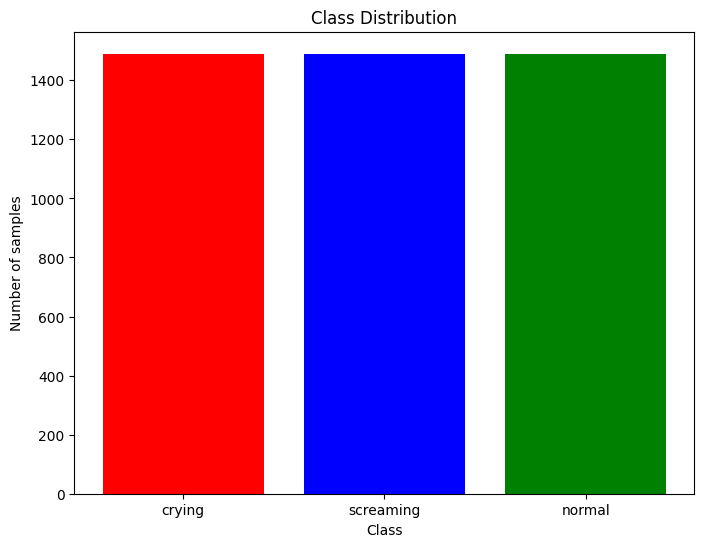

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import wiener
from scipy.ndimage import gaussian_filter1d
import soundfile as sf
from tqdm import tqdm

output_dir = "Processed_Audio"
csv_file = "processed_audio_metadata.csv"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def preprocess_audio(file_path, target_sr=16000):
    """Load audio with consistent sampling rate and in mono."""
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    return audio

def segment_audio(audio, segment_length=2, sr=16000):
    """Segment audio into fixed-length segments (in seconds)."""
    segment_samples = segment_length * sr
    segments = []
    for i in range(0, len(audio), segment_samples):
        seg = audio[i:i + segment_samples]
        if len(seg) == segment_samples:
            segments.append(seg)
    return segments

def advanced_preprocess(segment, sr=16000):
    """Apply advanced preprocessing:
       - Noise removal using a Wiener filter (with small epsilon in denominator to avoid division by zero)
       - Gaussian smoothing
       - Normalize the audio to [-1, 1]"""
    epsilon = 1e-6
    if len(segment) > 1:  # Wiener filter requires at least 2 samples
        try:
            segment = wiener(segment, noise=epsilon)
        except ValueError:
            pass  # Keep original if Wiener fails
    segment = gaussian_filter1d(segment, sigma=1)
    max_val = np.max(np.abs(segment))
    if max_val > 0:
        segment = segment / max_val
    return segment

def process_dataset_in_batches(dataset_path, label, sr=16000, batch_size=50):
    """Process files in batches to prevent crashes and save results to disk."""
    files = [f for f in os.listdir(dataset_path) if f.endswith(('.wav', '.mp3'))]
    metadata = []
    for batch_start in tqdm(range(0, len(files), batch_size), desc=f"Processing {label} dataset in batches"):
        batch_files = files[batch_start:batch_start + batch_size]
        for file in batch_files:
            file_path = os.path.join(dataset_path, file)
            audio = preprocess_audio(file_path, sr)
            segments = segment_audio(audio, sr=sr)
            for idx, seg in enumerate(segments):
                seg = advanced_preprocess(seg, sr)
                file_id = f"{os.path.splitext(file)[0]}_seg{idx}"
                filename = f"{file_id}.wav"
                filepath = os.path.join(output_dir, filename)
                sf.write(filepath, seg, sr)  # Save processed segment
                metadata.append({'file_name': filename, 'label': label})
    return metadata

# Process datasets
crying_metadata = process_dataset_in_batches("Dataset/Cry_Datasets", 'crying')
screaming_metadata = process_dataset_in_batches("Dataset/Screaming_Datasets", 'screaming')
normal_metadata = process_dataset_in_batches("Dataset/Normal_Utterances_Datasets", 'normal')

# Find the minimum count among all classes
min_count = min(len(crying_metadata), len(screaming_metadata), len(normal_metadata))

# Downsample the datasets by keeping the first `min_count` elements
crying_metadata = crying_metadata[:min_count]
screaming_metadata = screaming_metadata[:min_count]
normal_metadata = normal_metadata[:min_count]

# Combine metadata
final_metadata = crying_metadata + screaming_metadata + normal_metadata

# Compute class weights
def compute_class_weights(metadata):
    """Compute class weights based on the inverse frequency of each class."""
    class_counts = {}
    for item in metadata:
        label = item['label']
        class_counts[label] = class_counts.get(label, 0) + 1
    total_samples = sum(class_counts.values())
    class_weights = {label: total_samples / (len(class_counts) * count) for label, count in class_counts.items()}
    return class_weights

class_weights = compute_class_weights(final_metadata)
print("Class Weights:", class_weights)

# Report data statistics
print("Total data points:", len(final_metadata))
class_counts = {
    'crying': len(crying_metadata),
    'screaming': len(screaming_metadata),
    'normal': len(normal_metadata)
}
print("Class distribution:", class_counts)

# Save metadata to CSV
df = pd.DataFrame(final_metadata)
df.to_csv(csv_file, index=False)

# Plot histogram of class distribution
plt.figure(figsize=(8,6))
plt.bar(class_counts.keys(), class_counts.values(), color=['red', 'blue', 'green'])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil

# Path to the metadata CSV and the processed audio folder
metadata_csv = "processed_audio_metadata.csv"
source_dir = "Processed_Audio"

# Load the metadata CSV
df = pd.read_csv(metadata_csv)

# Perform stratified split:
#   - First split into train (70%) and temp (30%)
#   - Then split temp equally into validation (15%) and test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Create output directories for splits
base_output_dir = "Split_Data"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# Function to copy audio files to the appropriate folder
def copy_files(split_df, destination):
    for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Copying files to {os.path.basename(destination)}"):
        file_name = row['file_name']
        src = os.path.join(source_dir, file_name)
        dst = os.path.join(destination, file_name)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"Warning: {src} not found.")

# Copy files for each split
copy_files(train_df, train_dir)
copy_files(val_df, val_dir)
copy_files(test_df, test_dir)

# Save metadata CSVs for each split
train_df.to_csv(os.path.join(base_output_dir, "train_metadata.csv"), index=False)
val_df.to_csv(os.path.join(base_output_dir, "val_metadata.csv"), index=False)
test_df.to_csv(os.path.join(base_output_dir, "test_metadata.csv"), index=False)

print("Data successfully split into train, validation, and test sets.")

Copying files to test: 100%|██████████| 671/671 [00:00<00:00, 1327.61it/s]

Data successfully split into train, validation, and test sets.
